# Week 7: Regressiemodellen in Machine Learning

## Bibliotheken importeren

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pyodbc

## Data inlezen en kolommen selecteren

In [2]:
# df = pd.read_csv("titanic.csv")
# df
DB_DWH = {"servername": r"localhost,1433", "database": "dwh", "username": "sa", "password": "iDTyjZx7dRL4"}

dwh_conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={DB_DWH['servername']};"
    f"DATABASE={DB_DWH['database']};"
    f"UID={DB_DWH['username']};"
    f"PWD={DB_DWH['password']}"
)



In [3]:
def create_dataframes_sql(connection):
    dictionary : dict = {}
    query : str = ""
    key : str = ""

    query = "SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE';"
    key = "TABLE_NAME"

    table_names = pd.read_sql(query, connection)

    for table in table_names[key].tolist():
        dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)

    return dictionary

dwh = create_dataframes_sql(dwh_conn)

print(list(dwh.keys()))

/var/folders/k4/8yvf4x0n4c15r7pl4lwy8x6m0000gp/T/ipykernel_5670/506354042.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  table_names = pd.read_sql(query, connection)
/var/folders/k4/8yvf4x0n4c15r7pl4lwy8x6m0000gp/T/ipykernel_5670/506354042.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dictionary[table] = pd.read_sql(f"SELECT * FROM {table}", connection)


['sales_staff', 'retailer_site', 'product', 'inventory_levels', 'order_details']


In [4]:
order_details = dwh['order_details'].loc[:, ['QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE', 'REVENUE', 'TOTAL_COST']]
order_details

,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE,REVENUE,TOTAL_COST
0,84,4.38,6.59,6.59,553.559998,367.920013
1,126,4.38,6.59,6.59,830.340027,551.880005
2,122,4.38,6.59,6.03,735.660034,534.359985
3,122,4.38,6.59,6.59,803.980042,534.359985
4,272,4.38,6.59,5.26,1430.720093,1191.359985
...,...,...,...,...,...,...
37752,70,6.00,9.00,9.00,630.000000,420.000000
37753,44,6.00,12.00,9.00,396.000000,264.000000
37754,8,80.00,200.00,140.00,1120.000000,640.000000
37755,24,5.00,10.00,10.00,240.000000,120.000000


## One-hot encoding van onafhankelijke niet-numerieke variabelen (NIET VAN TOEPASSING)

In [ ]:
# dummies_dataframe = pd.get_dummies(df.loc[:, ['Sex']])
# dummies_dataframe


,Sex_female,Sex_male
0,False,True
1,True,False
2,True,False
3,True,False
4,False,True
...,...,...
886,False,True
887,True,False
888,True,False
889,False,True


In [ ]:
# df = pd.concat([df, dummies_dataframe], axis = 1)
# df = df.drop(['Sex'], axis = 1)
# df = df.loc[:, ['Pclass', 'Sex_female', 'Sex_male', 'Age']]
# df

,Pclass,Sex_female,Sex_male,Age
0,3,False,True,22.0
1,1,True,False,38.0
2,3,True,False,26.0
3,1,True,False,35.0
4,3,False,True,35.0
...,...,...,...,...
886,2,False,True,27.0
887,1,True,False,19.0
888,3,True,False,NaN
889,1,False,True,26.0


## Verticaal en horizontaal snijden

In [6]:
X = order_details.loc[order_details['REVENUE'].notna(), :]
X = X.drop('REVENUE', axis = 1)
y = order_details.loc[order_details['REVENUE'].notna(), ['REVENUE']]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37757 entries, 0 to 37756
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QUANTITY         37757 non-null  int64  
 1   UNIT_COST        37757 non-null  float64
 2   UNIT_PRICE       37757 non-null  float64
 3   UNIT_SALE_PRICE  37757 non-null  float64
 4   TOTAL_COST       37757 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.7 MB


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state = 42
)

## Regressiemodel bouwen

In [8]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)
reg_model

LinearRegression()

In [9]:
y_pred= reg_model.predict(X_test)
y_pred

array([[183135.89714636],
       [  2250.84295439],
       [  1069.22635327],
       ...,
       [  4369.78479284],
       [   468.11851617],
       [   610.27749305]], shape=(5664, 1))

In [10]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'Predicted_Revenue'})
prediction_df

,Predicted_Revenue
0,183135.897146
1,2250.842954
2,1069.226353
3,449.781337
4,11680.736939
...,...
5659,2320.593123
5660,1028.801650
5661,4369.784793
5662,468.118516


In [11]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['REVENUE'], prediction_df], axis = 1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_Revenue'].notna(), :]

,REVENUE,Predicted_Revenue
0,175903.453125,183135.897146
1,2294.880127,2250.842954
2,984.200073,1069.226353
3,131.839996,449.781337
4,11287.679688,11680.736939
...,...,...
5659,2162.160156,2320.593123
5660,791.440002,1028.801650
5661,4819.200195,4369.784793
5662,218.699997,468.118516


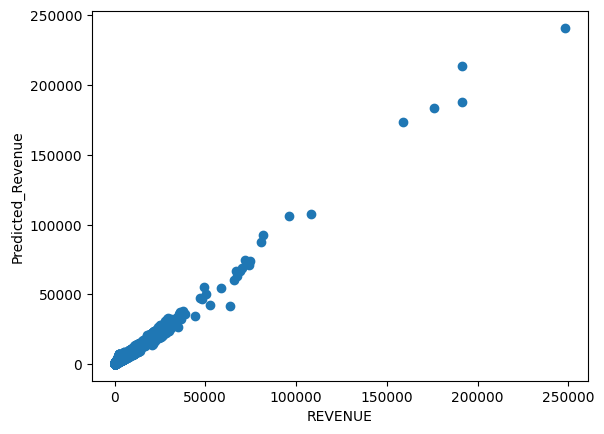

In [12]:
plt.scatter(y_test_prediction_merge['REVENUE'], y_test_prediction_merge['Predicted_Revenue'])
plt.xlabel('REVENUE')
plt.ylabel('Predicted_Revenue')
plt.show()

In [13]:
mean_squared_error(y_test_prediction_merge['REVENUE'], y_test_prediction_merge['Predicted_Revenue'])

976398.3628772359

In [14]:
mean_absolute_error(y_test_prediction_merge['REVENUE'], y_test_prediction_merge['Predicted_Revenue'])

473.86083625547764